## Casualty Analysis of Speeding Cases resulting in People Killed outside of Vehicle

There are 36,560 people died in car accidents in 2018, and 26% of the cases are speeding related.

### Research Question
In this notebook we will be analyzing speeding-related traffic crashes in 2015 that resulting the deaths outside of vehicle and exploring the contribution factors. We will use machine learning algorithms to analyze the data.

### Data Loading

The dataset is from Google BigQuery public data [NHTSA Traffic Fatalities](https://console.cloud.google.com/marketplace/product/nhtsa-data/nhtsa-traffic-fatalities?filter=solution-type:dataset&filter=category:public-safety&id=412c019d-62ba-4ee9-af00-04183e9ddb84) and [How to connect to Google BigQuery](https://cloud.google.com/bigquery/docs/quickstarts?hl=en_US)
For more detail about the dataset please visit [NHTSA Fatality Analysis Reporting System](https://www.nhtsa.gov/research-data/fatality-analysis-reporting-system-fars)
Here is the sample SQL code I used to query the data from BigQuery:
```
    SELECT
        ap.*, body_type,
        vehicle_trailing, gross_vehicle_weight_rating, travel_speed,
        previous_recorded_crashes, previous_recorded_suspensions_and_revocations, previous_dwi_convictions,
        previous_speeding_convictions, related_factors_driver_level_1, related_factors_driver_level_2,
        related_factors_driver_level_3, related_factors_driver_level_4, roadway_alignment, roadway_grade,
        roadway_surface_type, roadway_surface_condition, crash_type, fatalities_in_vehicle
        FROM (
        SELECT a.state_number, a.consecutive_number, number_of_forms_submitted_for_persons_not_in_motor_vehicles
        number_of_forms_submitted_for_persons_not_in_motor_vehicles, a.county, city, a.day_of_crash, a.month_of_crash,
        day_of_week, a.hour_of_crash, national_highway_system, a.land_use, a.functional_system,
        route_signing, a.first_harmful_event, a.manner_of_collision, relation_to_junction_within_interchange_area,
        relation_to_junction_specific_location, type_of_intersection, relation_to_trafficway, light_condition,
        atmospheric_conditions, related_factors_crash_level_1, related_factors_crash_level_2, related_factors_crash_level_3,
        number_of_fatalities, p.vehicle_number, p.person_number, p.rollover, p.age, p.sex, p.person_type, p.injury_severity,
        p.police_reported_alcohol_involvement, p.police_reported_drug_involvement, related_factors_person_level1,
        related_factors_person_level2, related_factors_person_level3, race
        FROM
        `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015` a
        LEFT JOIN
        `bigquery-public-data.nhtsa_traffic_fatalities.person_2015` p
        ON a.consecutive_number = p.consecutive_number
        WHERE p.person_type = 1
        ) ap
        JOIN
        `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2015` v
        ON ap.vehicle_number = v.vehicle_number
        WHERE speeding_related LIKE '%Yes%' and number_of_forms_submitted_for_persons_not_in_motor_vehicles > 0
        LIMIT 100000
```
I wrote is simple [script](bq.py) to convert the data from Google Big Query to Data Frame.

In [56]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../Downloads/NHTSA-Daisy-5dde7049e0be.json"

### Data Preprocess and Exploration

In [57]:
import bq

query = """
SELECT * FROM `nhtsa-daisy.fars_2015.fars_apv_2015_ped`
"""
df = bq.to_df(query)
df.info

<bound method DataFrame.info of        state_number  consecutive_number  \
0                53              530365   
1                53              530365   
2                53              530365   
3                53              530365   
4                53              530365   
...             ...                 ...   
99995            26              260166   
99996            26              260166   
99997            26              260166   
99998            26              260166   
99999            26              260166   

       number_of_forms_submitted_for_persons_not_in_motor_vehicles  county  \
0                                                      1                33   
1                                                      1                33   
2                                                      1                33   
3                                                      1                33   
4                                                      1     

Now we need to create our target. The target is calculated from the number of total fatalities of the crash minus fatalities in the car. If the number bigger than 0, the speeding crash result in people death outside of vehicle, vise versa.

0    84318
1    15682
Name: death, dtype: int64


<AxesSubplot:>

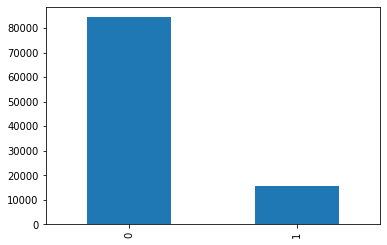

In [59]:
df['death'] = df.apply(lambda row: 1 if (row.number_of_fatalities - row.fatalities_in_vehicle > 0) else 0, axis=1)
print(df['death'].value_counts())
df['death'].value_counts().plot(kind='bar')

As you can see the target is not very balance, we could up-sample minority class or down-sample majority class. Here we choose to down-sample majority class

<AxesSubplot:>

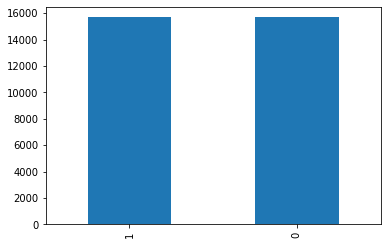

In [72]:
from sklearn.utils import resample
import pandas as pd
df_majority = df[df.death==0]
df_minority = df[df.death==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=15682,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_downsampled.death.value_counts())
df_downsampled['death'].value_counts().plot(kind='bar')


Then we need to drop some columns.

In [63]:
df_downsampled = df_downsampled.drop(['consecutive_number', 'number_of_fatalities', 'fatalities_in_vehicle', 'number_of_forms_submitted_for_persons_not_in_motor_vehicles'], axis=1)

We have some categorical columns, so we need to encode them into numeric.

In [64]:
df_downsampled["relation_to_junction_within_interchange_area"] = df_downsampled.apply(
    lambda row: 1 if (row.relation_to_junction_within_interchange_area == 'Yes') else 0, axis=1)

df_downsampled['vehicle_trailing'] = df_downsampled['vehicle_trailing'].str[0:3]
df_downsampled['vehicle_trailing'] = df_downsampled.apply(
    lambda row: 0 if (row.vehicle_trailing == 'No ') else 1, axis=1)

labels = df_downsampled['gross_vehicle_weight_rating'].astype('category').cat.categories.tolist()
replace_map_comp = {'gross_vehicle_weight_rating': {k: v for k, v in zip(labels, list(range(0, len(labels) + 1)))}}
df_downsampled.replace(replace_map_comp, inplace=True)

labels2 = df_downsampled['roadway_alignment'].astype('category').cat.categories.tolist()
replace_map_comp2 = {'roadway_alignment': {k: v for k, v in zip(labels2, list(range(1, len(labels2) + 1)))}}
df_downsampled.replace(replace_map_comp2, inplace=True)

labels3 = df_downsampled['roadway_grade'].astype('category').cat.categories.tolist()
replace_map_comp3 = {'roadway_grade': {k: v for k, v in zip(labels3, list(range(1, len(labels3) + 1)))}}
df_downsampled.replace(replace_map_comp3, inplace=True)

labels4 = df_downsampled['roadway_surface_type'].astype('category').cat.categories.tolist()
replace_map_comp4 = {'roadway_surface_type': {k: v for k, v in zip(labels4, list(range(1, len(labels4) + 1)))}}
df_downsampled.replace(replace_map_comp4, inplace=True)

labels5 = df_downsampled['type_of_intersection'].astype('category').cat.categories.tolist()
replace_map_comp5 = {'type_of_intersection': {k: v for k, v in zip(labels5, list(range(1, len(labels5) + 1)))}}
df_downsampled.replace(replace_map_comp5, inplace=True)

df_downsampled['rollover'] = df_downsampled['rollover'].str[0:2]
df_downsampled['rollover'] = df_downsampled.apply(
    lambda row: 0 if (row.rollover == 'No') else 1, axis=1)

df_downsampled['police_reported_alcohol_involvement'] = df_downsampled['police_reported_alcohol_involvement'].str[0:3]
df_downsampled['police_reported_alcohol_involvement'] = df_downsampled.apply(
    lambda row: 1 if (row.police_reported_alcohol_involvement == 'Yes') else 0, axis=1)

df_downsampled['police_reported_drug_involvement'] = df_downsampled['police_reported_drug_involvement'].str[0:3]
df_downsampled['police_reported_drug_involvement'] = df_downsampled.apply(
    lambda row: 1 if (row.police_reported_drug_involvement == 'Yes') else 0, axis=1)

df_downsampled['sex'] = df_downsampled.apply(
    lambda row: 0 if (row.sex == 'Female') else 1, axis=1)

Split training set and testing set

In [65]:
from sklearn.model_selection import train_test_split

X = df_downsampled.drop(['death'], axis=1)
y = df_downsampled['death']

### Feature Selection

In [66]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import numpy as np

extra_tree_forest = ExtraTreesClassifier(n_estimators=10, criterion ='entropy')

extra_tree_forest.fit(X, y)
# Computing the importance of each feature 
feature_importance = extra_tree_forest.feature_importances_ 

feature_importance_df = pd.DataFrame({'feature_names':np.array(X.columns),
                                      'feature_importance':np.array(feature_importance)})

print(feature_importance_df.sort_values(by=['feature_importance'], ascending=False))

                                    feature_names  feature_importance
51                                     crash_type            0.247870
35                                      body_type            0.132538
47                              roadway_alignment            0.091285
43                 related_factors_driver_level_1            0.083221
38                                   travel_speed            0.066792
48                                  roadway_grade            0.049648
40  previous_recorded_suspensions_and_revocations            0.041595
50                      roadway_surface_condition            0.040404
42                  previous_speeding_convictions            0.040245
39                      previous_recorded_crashes            0.039177
49                           roadway_surface_type            0.037744
44                 related_factors_driver_level_2            0.035849
36                               vehicle_trailing            0.019171
41                  

In [68]:
print(list(feature_importance_df.sort_values(by=['feature_importance'], ascending=False)[:10]['feature_names']))

['crash_type', 'body_type', 'roadway_alignment', 'related_factors_driver_level_1', 'travel_speed', 'roadway_grade', 'previous_recorded_suspensions_and_revocations', 'roadway_surface_condition', 'previous_speeding_convictions', 'previous_recorded_crashes']


Here we have the list of features importance.

The top 10 features are 'crash_type', 'body_type', 'roadway_alignment', 'related_factors_driver_level_1', 'travel_speed', 'roadway_grade', 'previous_recorded_suspensions_and_revocations', 'roadway_surface_condition', 'previous_speeding_convictions', 'previous_recorded_crashes'.

from sklearn.model_selection import train_test_split

X = df_downsampled[['crash_type', 'body_type', 'roadway_alignment', 'related_factors_driver_level_1', 'travel_speed', 'roadway_grade', 'previous_recorded_suspensions_and_revocations', 'roadway_surface_condition', 'previous_speeding_convictions', 'previous_recorded_crashes']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

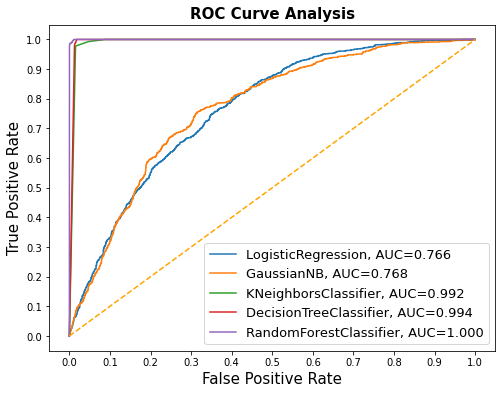

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd

classifiers = [LogisticRegression(random_state=1234),
               GaussianNB(),
               KNeighborsClassifier(),
               DecisionTreeClassifier(random_state=1234),
               RandomForestClassifier(random_state=1234)]

result_table = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::, 1]

    fpr, tpr, _ = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)

    result_table = result_table.append({'classifiers': cls.__class__.__name__,
                                        'fpr': fpr,
                                        'tpr': tpr,
                                        'auc': auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)
print(result_table)